# Predict Fuel Efficiency of a Vehicle <a id='top'></a>
Welcome, in this notebook we will build a regression model that can predict a vehicle's fuel efficiency in mpg.

The dataset used to build the model was downloaded from [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University. The dataset was used in the 1983 American Statistical Association Exposition.

This dataset is a slightly modified version of the dataset provided in the StatLib library. In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had unknown values for the "mpg" attribute. The original dataset is available in the file "auto-mpg.data-original".

"The data concerns city-cycle fuel consumption in miles per gallon, to be predicted in terms of 3 multivalued discrete and 5 continuous attributes." (Quinlan, 1993)

Table of contents:
* [Data exploration](#data-exploration)
* [Plotting categorical data](#cat-data)
* [Plotting continuous data](#continuous-data)
* [Build regression models](#build-models)
* [Predict a new data](#new-data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
plt.style.use('seaborn-darkgrid')
sns.set_style('darkgrid')


In [3]:
pio.renderers.default = 'notebook_connected'


## Data exploration <a id='data-exploration'></a>
[Back to top](#top)

In [4]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower',
                'weight', 'acceleration', 'model year', 'origin', 'car name']
df_vehicles = pd.read_csv('./data/auto-mpg.csv',
                          delim_whitespace=True,
                          names=column_names)
df_vehicles.head()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


The descriptions for each feature are as follows:

* mpg: miles per gallon.
* cylinders: number of cylinders. **(categorical)**
* displacement: engine displacement (cubic inches).
* horsepower.
* weight: vehicle weight (lbs).
* acceleration: time to accelerate from O to 60 mph (sec).
* model year (modulo 100). **(categorical)**
* origin: origin of car (1. American, 2. European, 3. Japanese). **(categorical)**
* and the car name.

In [5]:
df_vehicles.shape


(398, 9)

In [6]:
df_vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [7]:
df_vehicles.isna().sum()


mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

There is no `na` values at all. But notice the dtype of the **horsepower** column is object not float. Let's take a look:

In [8]:
df_vehicles['horsepower'].unique()


array(['130.0', '165.0', '150.0', '140.0', '198.0', '220.0', '215.0',
       '225.0', '190.0', '170.0', '160.0', '95.00', '97.00', '85.00',
       '88.00', '46.00', '87.00', '90.00', '113.0', '200.0', '210.0',
       '193.0', '?', '100.0', '105.0', '175.0', '153.0', '180.0', '110.0',
       '72.00', '86.00', '70.00', '76.00', '65.00', '69.00', '60.00',
       '80.00', '54.00', '208.0', '155.0', '112.0', '92.00', '145.0',
       '137.0', '158.0', '167.0', '94.00', '107.0', '230.0', '49.00',
       '75.00', '91.00', '122.0', '67.00', '83.00', '78.00', '52.00',
       '61.00', '93.00', '148.0', '129.0', '96.00', '71.00', '98.00',
       '115.0', '53.00', '81.00', '79.00', '120.0', '152.0', '102.0',
       '108.0', '68.00', '58.00', '149.0', '89.00', '63.00', '48.00',
       '66.00', '139.0', '103.0', '125.0', '133.0', '138.0', '135.0',
       '142.0', '77.00', '62.00', '132.0', '84.00', '64.00', '74.00',
       '116.0', '82.00'], dtype=object)

We can see that there is a `?` placeholder for missing values.

In [9]:
df_vehicles[df_vehicles['horsepower'] == '?']


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
32,25.0,4,98.0,?,2046.0,19.0,71,1,ford pinto
126,21.0,6,200.0,?,2875.0,17.0,74,1,ford maverick
330,40.9,4,85.0,?,1835.0,17.3,80,2,renault lecar deluxe
336,23.6,4,140.0,?,2905.0,14.3,80,1,ford mustang cobra
354,34.5,4,100.0,?,2320.0,15.8,81,2,renault 18i
374,23.0,4,151.0,?,3035.0,20.5,82,1,amc concord dl


There are 6 entries that have `?` as a placeholder for missing values. I don't want to drop those rows, I want to replace them with `nan` values and then I can decide to fill them with mean or median.

In [10]:
df_vehicles['horsepower'] = df_vehicles['horsepower'].replace(
    '?', np.nan, regex=False)


In [11]:
print('?' in df_vehicles['horsepower'])


False


Ok so now that we have replace the `?` with `nan`. Let's check the dtype again:

In [12]:
df_vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


It's still an object dtype column. That's because when we imported the dataset using `pd.read_csv`, pandas coerced the column as object. We have to manually change its dtype to numeric.

In [13]:
df_vehicles['horsepower'] = pd.to_numeric(df_vehicles['horsepower'])
df_vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


That's good. Now I want to see the statistics of the entire DataFrame.

In [14]:
df_vehicles.describe()


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [15]:
fig = px.histogram(
    data_frame=df_vehicles,
    x='horsepower',
    marginal='box',
    labels={'horsepower': 'Horsepower'}
)

fig.show()


I decided to replace the `nan` values with the median since adding more median values does not change much the distribution histogram.

In [16]:
median_power = df_vehicles['horsepower'].median()
df_vehicles['horsepower'] = df_vehicles['horsepower'].fillna(median_power)
df_vehicles.isna().any()


mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

## Plotting categorical data <a id='cat-data'></a>
[Back to top](#top)

Good, we have replaced the `nan` with the median. Now let's look at the categorical columns.

First of all, let's see the counts of each unique values in those columns:

In [17]:
categorical_columns = ['cylinders', 'model year', 'origin']

for col in categorical_columns:
    print(
        f'Value counts of "{df_vehicles[col].name}" column:\n{df_vehicles[col].value_counts()}')
    print()


Value counts of "cylinders" column:
4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

Value counts of "model year" column:
73    40
78    36
76    34
82    31
75    30
70    29
79    29
80    29
81    29
71    28
72    28
77    28
74    27
Name: model year, dtype: int64

Value counts of "origin" column:
1    249
3     79
2     70
Name: origin, dtype: int64



I probably want to replace the `1, 2, 3` values with `American, European, Japanese` in the `origin` column for better visualization. Then turn the dtype of `cylinders`, `model year` and `origin` into categorical dtype.

In [18]:
# replace [1, 2, 3] with ['American', 'European', 'Japanese']
df_vehicles['origin'] = df_vehicles['origin'].replace(
    to_replace=[1, 2, 3], value=['American', 'European', 'Japanese'])

# convert dtype to 'category'
df_vehicles['cylinders'] = df_vehicles['cylinders'].astype('category')
df_vehicles['model year'] = df_vehicles['model year'].astype('category')
df_vehicles['origin'] = df_vehicles['origin'].astype('category')


Now I want to create a boxplot to see how each categorical column affects a vehicle's performance.

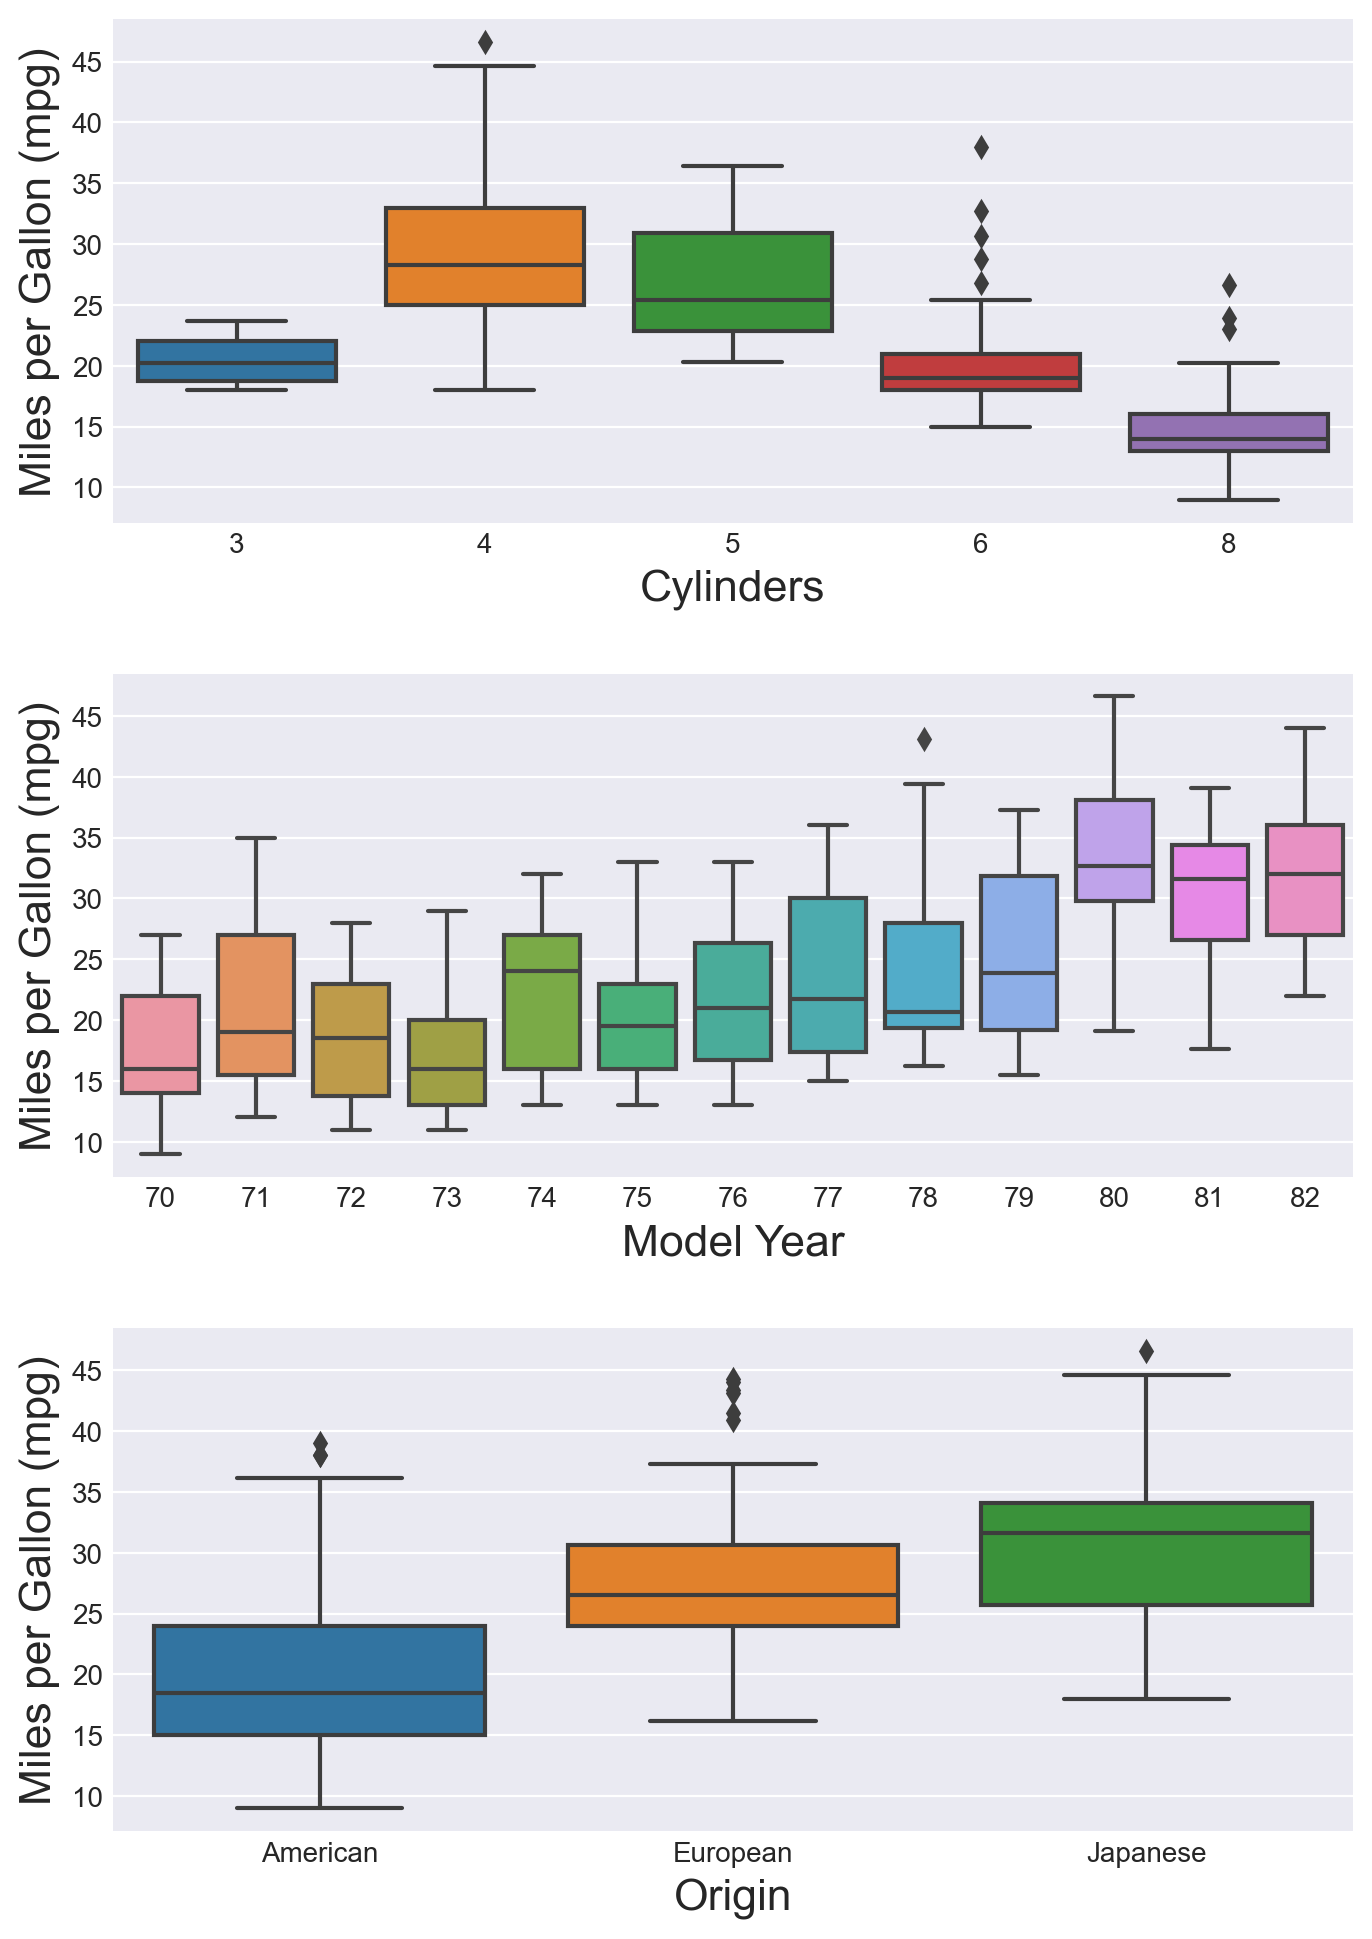

In [19]:
fig, axes = plt.subplots(figsize=(8, 12), dpi=200,
                         nrows=3, ncols=1, gridspec_kw={'hspace': 0.3})

for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='mpg', data=df_vehicles, ax=axes[i])
    axes[i].set_ylabel('Miles per Gallon (mpg)', fontsize=16)
    axes[i].set_xlabel(col.title(), fontsize=16)

plt.show()


From the above plot, it looks like cars with 4 cylinders generally achive higher mileage. For the `model year` column, the later the year when the car was produced, the better the performance.

Last but not least, overall, Japanese cars seem to be more fuel efficient.

## Plotting continuous data <a id='continuous-data'></a>
[Back to top](#top)

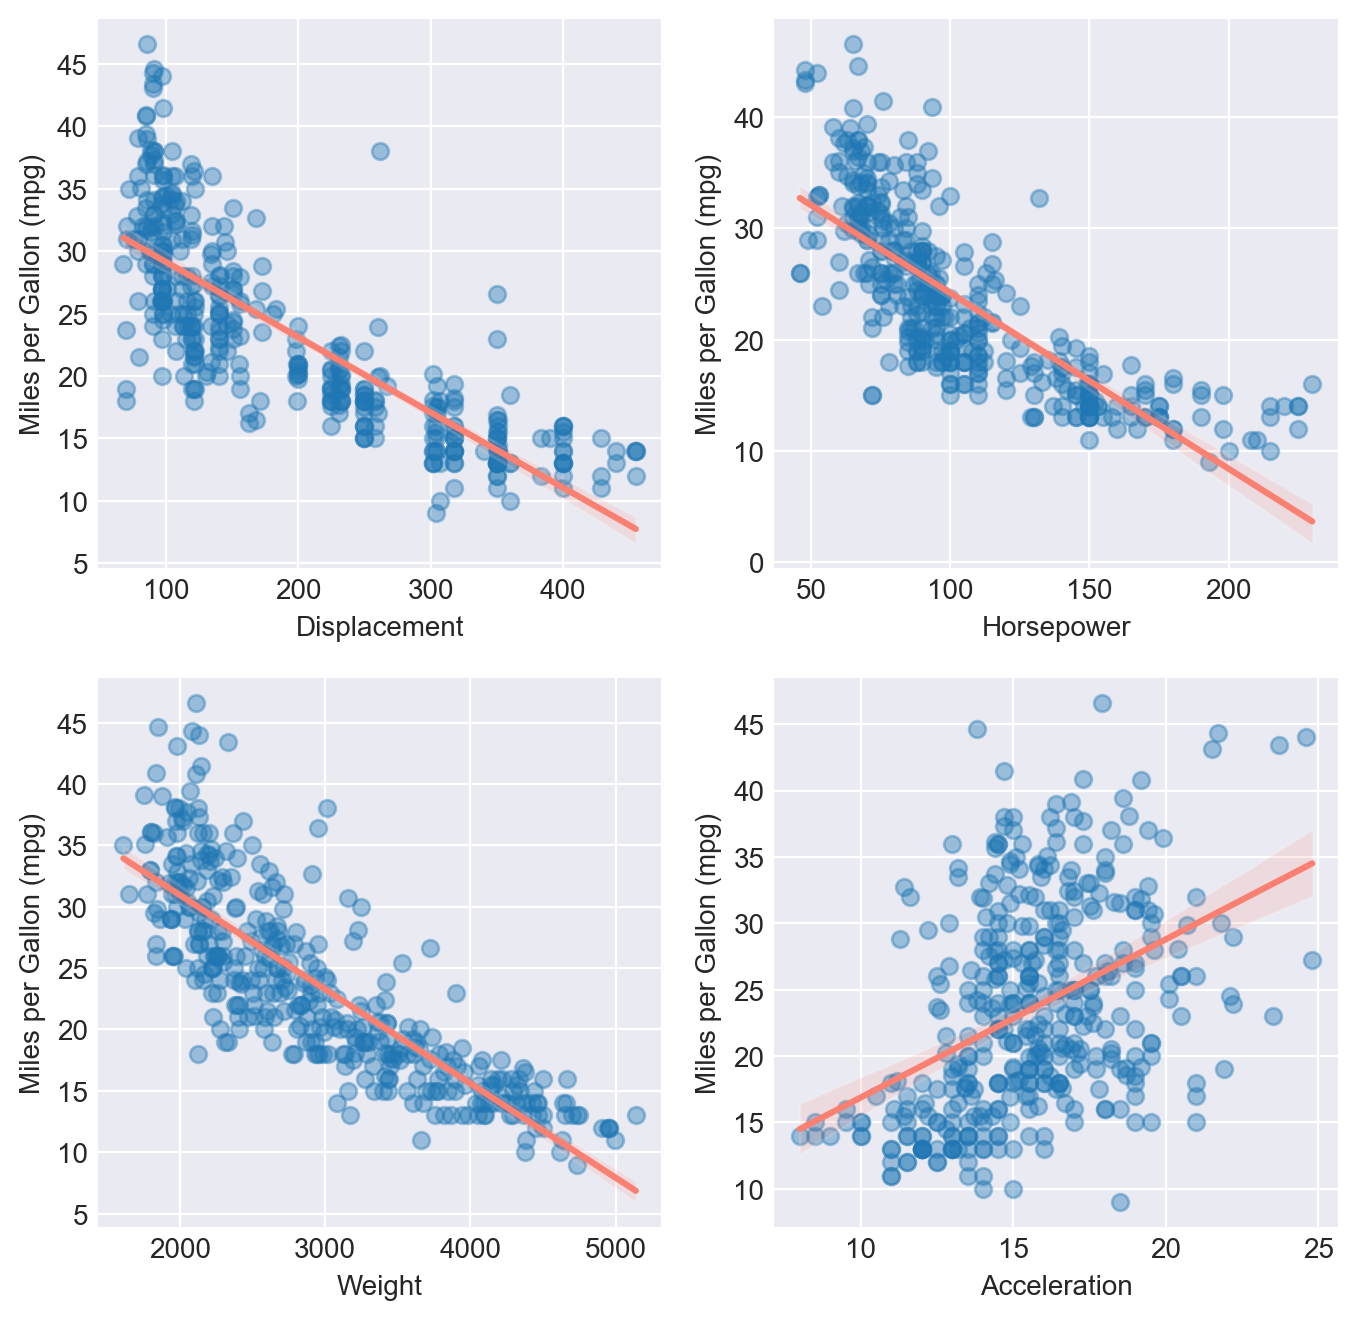

In [20]:
continuous_columns = ['displacement', 'horsepower', 'weight', 'acceleration']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), dpi=200, gridspec_kw={'wspace': 0.2,
                                                                                  'hspace': 0.2})

# upper left axe
sns.regplot(data=df_vehicles, x=continuous_columns[0], y='mpg',
            fit_reg=True, ax=axes[0, 0],
            line_kws={'color': 'salmon'},
            scatter_kws={'alpha': 0.4})
axes[0, 0].set_ylabel('Miles per Gallon (mpg)', fontsize=10)
axes[0, 0].set_xlabel(continuous_columns[0].title(), fontsize=10)

# upper right axe
sns.regplot(data=df_vehicles, x=continuous_columns[1], y='mpg',
            fit_reg=True, ax=axes[0, 1],
            line_kws={'color': 'salmon'},
            scatter_kws={'alpha': 0.4})
axes[0, 1].set_ylabel('Miles per Gallon (mpg)', fontsize=10)
axes[0, 1].set_xlabel(continuous_columns[1].title(), fontsize=10)

# lower left axe
sns.regplot(data=df_vehicles, x=continuous_columns[2], y='mpg',
            fit_reg=True, ax=axes[1, 0],
            line_kws={'color': 'salmon'},
            scatter_kws={'alpha': 0.4})
axes[1, 0].set_ylabel('Miles per Gallon (mpg)', fontsize=10)
axes[1, 0].set_xlabel(continuous_columns[2].title(), fontsize=10)

# lower right axe
sns.regplot(data=df_vehicles, x=continuous_columns[3], y='mpg',
            fit_reg=True, ax=axes[1, 1],
            line_kws={'color': 'salmon'},
            scatter_kws={'alpha': 0.4})
axes[1, 1].set_ylabel('Miles per Gallon (mpg)', fontsize=10)
axes[1, 1].set_xlabel(continuous_columns[3].title(), fontsize=10)

plt.show()


Looks like the weight of vehicles affect their mileage the most. But let's develop our argument further by using seaborn heatmap to visualize the correlation.

In [21]:
df_corr = df_vehicles.corr()
df_corr

,mpg,displacement,horsepower,weight,acceleration
mpg,1.000000,-0.804203,-0.773453,-0.831741,0.420289
displacement,-0.804203,1.000000,0.895778,0.932824,-0.543684
horsepower,-0.773453,0.895778,1.000000,0.862442,-0.686590
weight,-0.831741,0.932824,0.862442,1.000000,-0.417457
acceleration,0.420289,-0.543684,-0.686590,-0.417457,1.000000


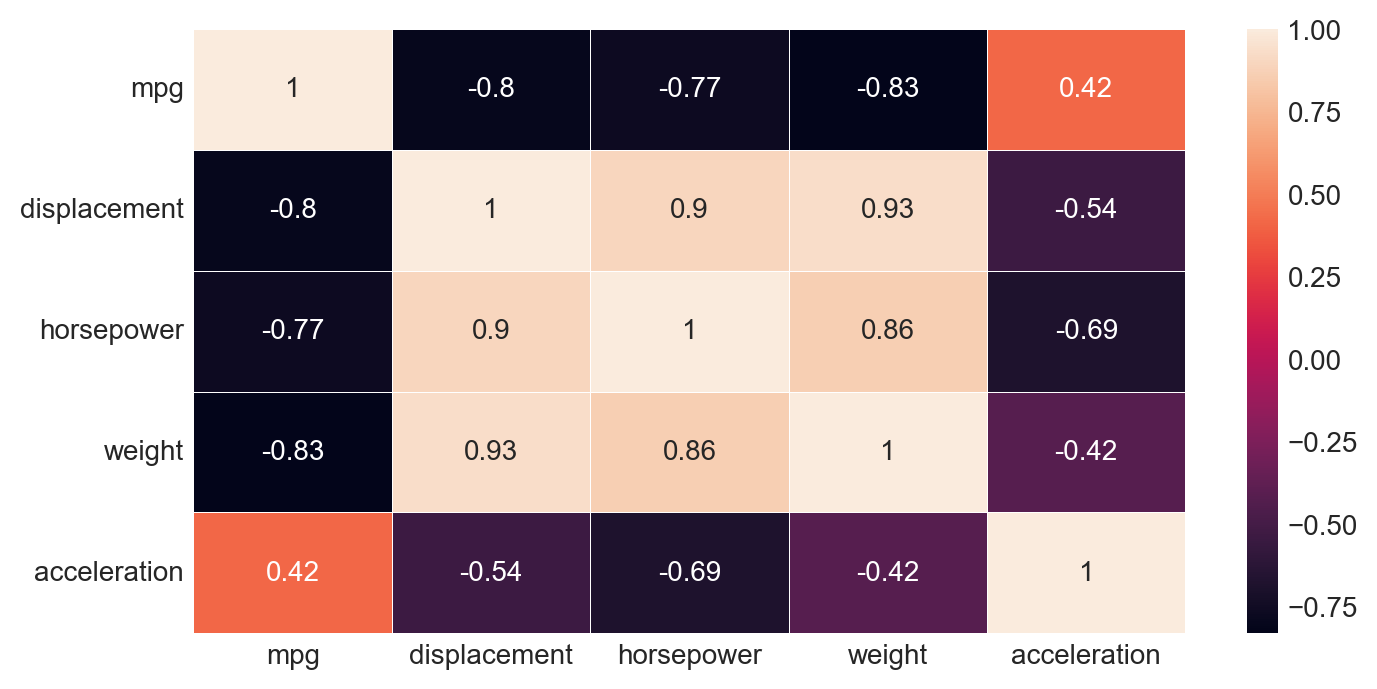

In [22]:
plt.figure(figsize=(8, 4), dpi=200)

sns.heatmap(data=df_corr,
            annot=True,
            linewidths=0.3)

plt.show()


As expected, the weight does affect the vehicle's mpg in a negative relationship. What I mean is, the more weight added, the less miles traveled per gallon.

The displacement and horsepower affect our vehicle the same way as well.

The same can not be said for acceleration which positively affect our vehicle but not as strong.

## Build machine learning models <a id='build-models'></a>

[Back to top](#top)

Now that we know what our data relationships look like, lets use some machine learning models to predict the value of MPG given the feature. We will use scikit-learn to train and test regression models on our data and compare the results. We will leverage the following regression models:
* [Linear Regression](#linear-regression).
* [Polinomial Regression](#polynomial-regression).

But first we probably want to drop the `car name` column. The column contains cars' names which have nothing to do with our vehicles' performance.

In [23]:
X = df_vehicles.drop(['mpg', 'car name'], axis=1)
y = df_vehicles['mpg']

In [24]:
# one-hot encode the categorical columns
one_hot = OneHotEncoder(handle_unknown='ignore')

ct = ColumnTransformer([('one_hot', one_hot, categorical_columns)],
                       remainder='passthrough')
X = ct.fit_transform(X)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=100)


### Fit the Linear Regression model <a id='linear-regression'></a>
[Back to main section](#build-models)

In [26]:
lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)

LinearRegression()

R_squared score:

In [27]:
lin_regressor.score(X_test, y_test)

0.8519260381830056

In [28]:
y_pred = lin_regressor.predict(X_test)

def print_regression_scores(y_true, y_pred):
    '''
    Prints mae score, mse score and rmse score
    '''
    mae_score = mean_absolute_error(y_true, y_pred)
    mse_score = mean_squared_error(y_true, y_pred)
    rmse_score = np.sqrt(mse_score)

    print(f'Mean absolute error score: {mae_score}')
    print(f'Mean squared error score: {mse_score}')
    print(f'Root mean squared error score: {rmse_score}')

print_regression_scores(y_test, y_pred)


Mean absolute error score: 2.294317386747901
Mean squared error score: 8.852704533540017
Root mean squared error score: 2.975349480908086


### Fit polynomial regression model <a id='polynomial-regression'></a>
[Back to main section](#build-models)

In [29]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_converter.fit_transform(X)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y,
                                                                        test_size=0.3, random_state=100)
lin_regressor_poly = LinearRegression()
lin_regressor_poly.fit(X_train_poly, y_train_poly)


LinearRegression()

R_squared score:

In [30]:
lin_regressor_poly.score(X_test_poly, y_test_poly)

0.8752283488132959

In [31]:
y_pred_poly = lin_regressor_poly.predict(X_test_poly)

print_regression_scores(y_test_poly, y_pred_poly)

Mean absolute error score: 2.059430558287014
Mean squared error score: 7.459559726530116
Root mean squared error score: 2.7312194577752473


Base on the R_squared and other metrics, looks like the polynomial model performs slightly better than the linear regression model. But let's try out different degrees to see how far we can push our polynomial model:

In [32]:
train_rmse_scores = []
test_rmse_scores = []

for deg in range(1, 6):
    poly_converter = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly = poly_converter.fit_transform(X)

    X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y,
                                                                        test_size=0.3, random_state=100)
    
    lin_regressor_poly = LinearRegression()
    lin_regressor_poly.fit(X_train_poly, y_train_poly)

    train_pred_poly = lin_regressor_poly.predict(X_train_poly)
    test_pred_poly = lin_regressor_poly.predict(X_test_poly)

    train_rmse = np.sqrt(mean_squared_error(y_train_poly, train_pred_poly))
    test_rmse = np.sqrt(mean_squared_error(y_test_poly, test_pred_poly))

    train_rmse_scores.append(train_rmse)
    test_rmse_scores.append(test_rmse)


In [33]:
train_test_poly_df = pd.DataFrame({'train_rmse': train_rmse_scores,
                                   'test_rmse': test_rmse_scores})
train_test_poly_df


,train_rmse,test_rmse
0,2.750831,2.975349
1,2.026114,2.731219
2,2.128336,3.252287
3,2.433233,3.689628
4,2.879160,4.490847


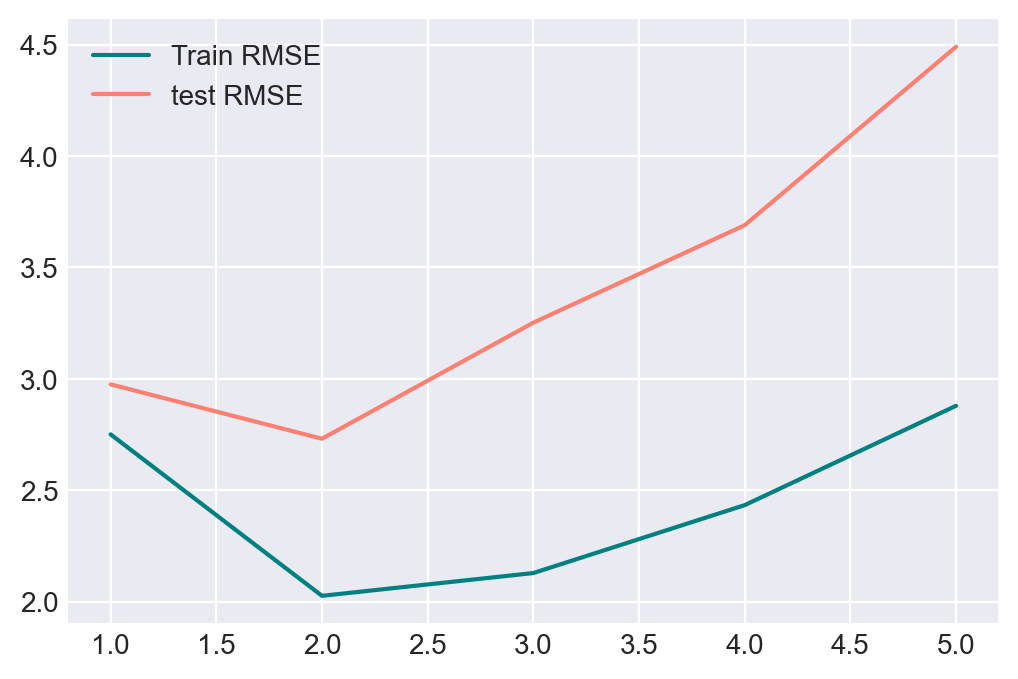

In [34]:
plt.figure(figsize=(6, 4), dpi=200)

plt.plot(range(1, 6), train_test_poly_df['train_rmse'], c='teal', label='Train RMSE')
plt.plot(range(1, 6), train_test_poly_df['test_rmse'], c='salmon', label='test RMSE')

plt.legend()
plt.show()


So it looks like our polynomial regression model performs best with degree=2.

Now we train the model on the whole dataset and try to predict a new data.

## Predict a single data <a id='new-data'></a>
[Back to top](#top)

In [35]:
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_converter.fit_transform(X)

final_model = LinearRegression()
final_model.fit(X_poly, y)

LinearRegression()

In [36]:
X_poly.shape

(398, 350)

For example: we have a car that has 8 cylinders, displacement: 351, horsepower: 172, weight: 3593, acceleration: 11, model year: 82, origin: Japanese. Let's use our polynomial model to predict the mpg.

In [37]:
example_car = pd.DataFrame({'cylinders': 8,
                            'displacement': 351,
                            'horsepower': 172,
                            'weight': 3593,
                            'acceleration': 11,
                            'model year': 82,
                            'origin': 'Japanese'},
                            index=[0])
example_car


,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,8,351,172,3593,11,82,Japanese


In [38]:
example_car = ct.transform(example_car)
example_car = poly_converter.transform(example_car)
example_result = final_model.predict(example_car)
example_result

array([14.21320924])

Probably right.